## Variables

In [1]:
data_path = "/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData"

# 1. 2D Dataset

## 1.1 Functions

In [2]:
import pandas as pd
import nibabel as nib
import SimpleITK as sitk
import os
import numpy as np
import random
from pathlib import Path

### 1.1.1 Create dataset dict

In [3]:
def organ_mapper():
    label_dict = {
        0: "background",
        1: "spleen",
        2: "right kidney",
        3: "left kidney",
        4: "gallbladder",
        5: "esophagus",
        6: "liver",
        7: "stomach",
        8: "aorta",
        9: "inferior vena cava",
        10: "portal vein & splenic vein",
        11: "pancreas",
        12: "right adrenal gland",
        13: "left adrenal gland",
    }
    key_to_organ = label_dict
    organ_to_key = {v.lower(): k for k, v in label_dict.items()}
    return key_to_organ, organ_to_key


def transform_to_csv(data_root):
    """
    Transform the BTCV dataset to a csv file.
    Args:
        data_root (str): path to the BTCV dataset.

    Returns:
        annotations (list): list of dictionaries containing the images and their masks with a list of organs available in each scan.

    """

    annotations = []
    # images_dir = os.path.join(data_root, "imagesTr")
    # masks_dir = os.path.join(data_root, "labelsTr")
    # imgs = [images_dir + "/" + f for f in sorted(os.listdir(images_dir))]
    # masks = [masks_dir + "/" + f for f in sorted(os.listdir(masks_dir))]
    img_dir = os.path.join(data_path, "imagesTr")
    masks_dir = os.path.join(data_path, "labelsTr")
    imgs = Path(img_dir).glob("*.nii.gz")
    masks = Path(masks_dir).glob("*.nii.gz")
    
    for img_path, mask_path in zip(sorted(imgs), sorted(masks)):
        mask_nifti = nib.load(mask_path)
        mask_data = mask_nifti.get_fdata()
        organs = [int(organ) for organ in np.unique(mask_data).tolist()]
        annotations.append(
            {"img_path": str(img_path), "mask_path": str(mask_path), "organs": organs}
        )

    annotations_df = pd.DataFrame(annotations)
    # Save to CSV
    annotations_df.to_csv(os.path.join(data_root, "dataset.csv"), index=False, sep=",")

    return annotations

### 1.1.2 train & test split

In [4]:
def create_dataset(annotations ,organs, train_size, seed=42):
    """
    Load a specific number of slices from the BTCV dataset.
    Args:
        n_slices (int): Number of slices to load.

    Returns:
        slices_df (list): List of loaded slices.
    """
    random.seed(seed)
    # split the dataset to train and test sets
    annotations_random = random.sample(annotations, len(annotations))
    train_df = random.sample(annotations_random, train_size)
    test_df = [ann for ann in annotations if ann not in train_df]

    
    # create train & test flattened sets
    train_set = extract_slices(train_df, organs)
    test_set = extract_slices(test_df, organs)

    return train_set, test_set


In [5]:
def extract_slices(in_set, organs):
    out_set = []
    key_to_organ, organ_to_key = organ_mapper()
    for row in in_set:
        for organ in organs:
            organ_key = organ_to_key.get(organ)
            if organ_key is None:
                print(f"Organ {organ} not found in organ mapping. Skipping.")
                continue

            img_path = row["img_path"]
            mask_path = row["mask_path"]
            subject_organ = row["organs"]
            if organ_key not in subject_organ:
                continue
                    
            mask = sitk.ReadImage(mask_path)
            mask_arr = sitk.GetArrayFromImage(mask)  # Shape: (Depth, Height, Width)

            slices_with_organ = np.any(mask_arr == organ_key, axis=(1, 2))
            slices_indices = np.where(slices_with_organ)[0].tolist()
            out_set.append(
                {
                    "img_path": img_path,
                    "mask_path": mask_path,
                    "organ": organ,
                    "begin_slice": slices_indices[0],
                    "end_slice": slices_indices[-1],
                }
            )
    return out_set
        
        

### 1.1.3 Train Loop

In [6]:
def train_on_organ(train_set, organ, output_dir):
    """
    Train the model on a specific organ.
    Args:
        train_set (list): List of training data.
        organ (str): Organ to train on.
        output_dir (str): Directory to save the trained model.

    Returns:
        None
    """
    key_to_organ, organ_to_key = organ_mapper()
    organ_key = organ_to_key.get(organ.lower())
    
    if organ_key is None:
        print(f"Organ {organ} not found in organ mapping. Skipping training.")
        return

    # Filter the training set for the specific organ
    filtered_train_set = [item for item in train_set if item["organ"] == organ]
    
    # Here you would implement the training logic using filtered_train_set
    # For demonstration purposes, we will just print the paths
    for item in filtered_train_set:
        print(f"Training on {item['img_path']} for organ {key_to_organ[organ_key]}")

## Application

### Create dataset from data pth

In [13]:
annnotations = transform_to_csv(data_path)

In [14]:
annnotations

[{'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_000_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_000.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_001_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_001.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_002_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_002.nii.gz',
  'organs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_003_0000.nii.gz',
  'mask_path': '/home/ismail/pr

### Train & Test Split

In [15]:
train_set, test_set = create_dataset(annnotations, ["liver", "spleen", "right kidney", "left kidney"], train_size=18, seed=42)

In [16]:
train_set

[{'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_022.nii.gz',
  'organ': 'liver',
  'begin_slice': 56,
  'end_slice': 93},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_022.nii.gz',
  'organ': 'spleen',
  'begin_slice': 63,
  'end_slice': 83},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/labelsTr/img_022.nii.gz',
  'organ': 'right kidney',
  'begin_slice': 49,
  'end_slice': 72},
 {'img_path': '/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_022_0000.nii.gz',
  'mask_path': '/home/i

In [17]:
train_df = pd.DataFrame(train_set)
if not os.path.exists(os.path.join(data_path, "split")):
    os.makedirs(os.path.join(data_path, "split"))
    
train_df.to_csv(os.path.join(data_path, "split", "train_dataset.csv"), index=False, sep=",")
test_df = pd.DataFrame(test_set)
test_df.to_csv(os.path.join(data_path,"split", "test_dataset.csv"), index=False, sep=",")

In [23]:
from tqdm.notebook import tqdm  # Use this in Jupyter
import time

# More efficient than iterrows() - this will be faster and display progress better
for i in tqdm(range(len(train_df))):
    row = train_df.iloc[i]
    time.sleep(0.1)  # Simulating training time
    

  0%|          | 0/72 [00:00<?, ?it/s]

In [19]:
len(train_df), len(test_df)

(72, 48)

### 1.2.3 Train model

In [7]:
train_df = pd.read_csv(os.path.join(data_path, "split", "train_dataset.csv"))

In [8]:
from train_model import BTCVSliceDataset
# create a dataset for training for liver
train_dataset = BTCVSliceDataset(train_df, "liver")

In [9]:
# length of the dataset
train_dataset.__len__()

949

In [10]:
img_t, mask_t = train_dataset[7]

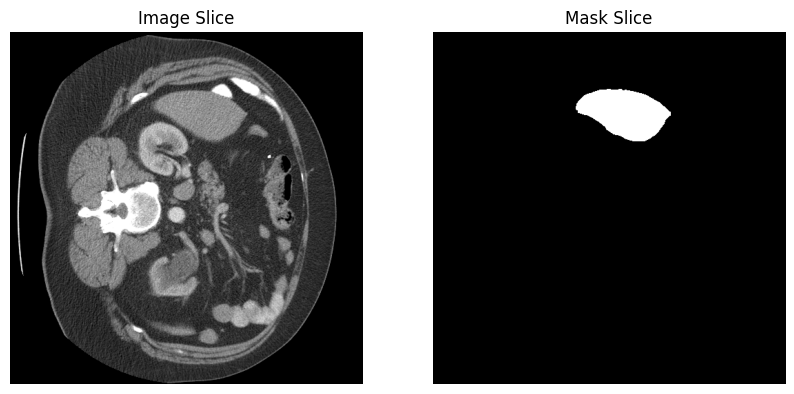

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_t[0], cmap='gray')
plt.title("Image Slice")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(mask_t[0], cmap='gray')
plt.title("Mask Slice")
plt.axis('off')
plt.show()

#### 1.2.3.1 Image Manipulation

In [12]:
img_path = train_df.iloc[0]["img_path"]
mask_path = train_df.iloc[0]["mask_path"]

img = nib.load(img_path)
mask = nib.load(mask_path)

# Get the specific slice
img_array = img.dataobj[:,:, train_df.iloc[0]["begin_slice"]+20].astype(np.float32)  # (H, W)
mask_array = mask.dataobj[:,:, train_df.iloc[0]["begin_slice"]+20].astype(np.float32)  # (H, W)

In [13]:
print(img_path)

/home/ismail/projet_PFE/Hands-on-nnUNet/nnUNetFrame/dataset/RawData/imagesTr/img_022_0000.nii.gz


In [14]:
print(train_df.iloc[0]["organ"])

liver


In [15]:
img_array.shape

(512, 512)

Base CT Scans

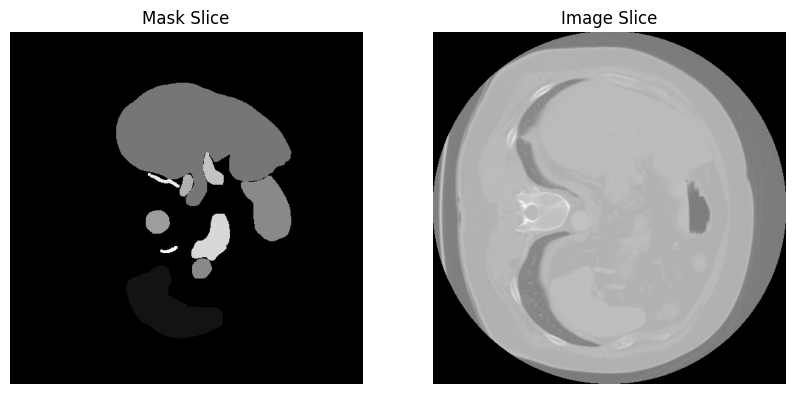

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_array, cmap='gray')
plt.title("Mask Slice")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_array, cmap='gray')
plt.title("Image Slice")
plt.axis('off')
plt.show()


Clipped CT Scans

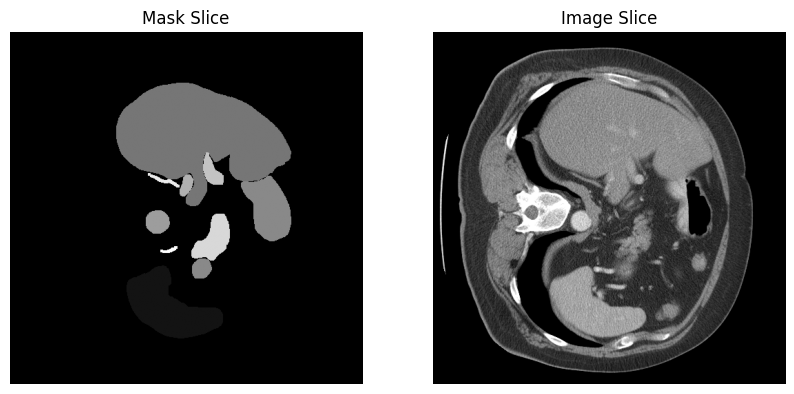

In [17]:
def clip_and_rescale(ct_array, min_hu=-175, max_hu=250):
    clipped = np.clip(ct_array, min_hu, max_hu)
    return (clipped + abs(min_hu)) / (max_hu + abs(min_hu))

mask_slice = clip_and_rescale(mask_array)
img_slice = clip_and_rescale(img_array)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask_slice, cmap='gray')
plt.title("Mask Slice")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img_slice, cmap='gray')
plt.title("Image Slice")
plt.axis('off')
plt.show()